### load library

In [1]:
import wordcloud
import nltk
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# NLP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import re

### load data

In [2]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

In [3]:
#uppercase letters to lowercase letters
train_set["tweet"] = train_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set["tweet"] = test_set["tweet"].apply(lambda x: " ".join(x.lower() for x in x.split()))
#delete numbers from tweet
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')
#delete stopwords from tweet
new_sw = ["RT", "user"]
sw = stopwords.words("english")
sw.extend(new_sw)
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
#lemmmatization
!pip install textblob
from textblob import Word
nltk.download('wordnet')
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

C:\Users\yuanhsu\AppData\Local\Temp\ipykernel_8296\2964910558.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_set['tweet'] = train_set['tweet'].str.replace('\d','')
C:\Users\yuanhsu\AppData\Local\Temp\ipykernel_8296\2964910558.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_set['tweet'] = test_set['tweet'].str.replace('\d','')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yuanhsu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# #stemmer
# from nltk.stem import PorterStemmer
# st = PorterStemmer ()
# train_set['tweet'][:5].apply (lambda x: " ".join ([st.stem(word) for word in x.split ()]))
# test_set['tweet'][:5].apply (lambda x: " ".join ([st.stem(word) for word in x.split ()]))

### Feature Engineering

In [5]:
train_df_fe = train_set.copy()
train_df_fe['tweet_length'] = train_df_fe['tweet'].str.len()
train_df_fe['num_hashtags'] = train_df_fe['tweet'].str.count('#')
# train_df_fe['num_exclamation_marks'] = train_df_fe['tweet'].str.count('\!')
# train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('\?')
train_df_fe['total_tags'] = train_df_fe['tweet'].str.count('@')
train_df_fe['num_punctuations'] = train_df_fe['tweet'].str.count('[.,:;]')
# train_df_fe['num_question_marks'] = train_df_fe['tweet'].str.count('[*&$%]')
train_df_fe['num_words'] = train_df_fe['tweet'].apply(lambda x: len(x.split()))
train_df_fe.head()

,class,tweet,tweet_length,num_hashtags,total_tags,num_punctuations,num_words
0,1,"[--] : pm ""son bitch ate mac n cheese"" http://...",58,0,0,3,10
1,1,rt @bryceserna: pussy grab booty. love booty. ...,63,0,1,4,9
2,2,rt @clicquotsuave: bunch rapper boutta flood i...,70,0,1,1,10
3,2,@michigannews wow. thats great language coming...,92,0,1,4,14
4,1,"i'm single, fuck bitch attitude foh.",36,0,0,2,6


In [6]:
test_df_fe = test_set.copy()
test_df_fe['tweet_length'] = test_df_fe['tweet'].str.len()
test_df_fe['num_hashtags'] = test_df_fe['tweet'].str.count('#')
test_df_fe['total_tags'] = test_df_fe['tweet'].str.count('@')
test_df_fe['num_punctuations'] = test_df_fe['tweet'].str.count('[.,:;]')
test_df_fe['num_words'] = test_df_fe['tweet'].apply(lambda x: len(x.split()))
test_df_fe.head()

,id,tweet,tweet_length,num_hashtags,total_tags,num_punctuations,num_words
0,0,!!!!!!! rt @urkindofbrand dawg!!!! rt @sbabyli...,90,0,2,1,13
1,1,!!!!!!!!! rt @c_g_anderson: @viva_based look l...,56,0,2,1,7
2,2,"!!!!!!""@__brighterdays: sit hate another bitch...",74,0,1,3,11
3,3,!!!!&#;@selfiequeenbri: cause i'm tired big bi...,76,2,1,3,10
4,4,""" @rhythmixx_ :hobbies include: fighting maria...",54,0,1,2,7


In [7]:
test_df_fe = test_df_fe.drop(columns=['id'],axis=1)

In [8]:
from sklearn import model_selection, preprocessing, linear_model, metrics
x = train_df_fe.drop(columns=['class'])
y = train_df_fe["class"]

train_x, val_x, train_y, val_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

In [9]:
print(train_x.shape,val_x.shape,train_y.shape,val_y.shape)

(11895, 6) (2974, 6) (11895,) (2974,)


In [10]:
test_df_fe.shape

(9914, 6)

#### Text normalization

In [11]:
# Function to tokenize and clean the text
def tokenize_and_clean(text):
    # Changing case of the text to lower case
    lowered = text.lower()
    
    # Cleaning the text
    cleaned = re.sub('@user', '', lowered)
    
    # Tokenization
    tokens = word_tokenize(cleaned)
    filtered_tokens = [token for token in tokens if re.match(r'\w{1,}', token)]
    
    # Stemming
    stemmer = PorterStemmer()
    stems = [stemmer.stem(token) for token in filtered_tokens]
    return stems

### Vectorize Data

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(train_x['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(val_x['tweet'])
print(X_train_tweets_tfidf.shape, X_test_tweets_tfidf.shape)

# TF-IDF Vectorization on full training data
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_and_clean, stop_words='english')
X_tweets_tfidf = tfidf_vectorizer.fit_transform(train_set['tweet'])
test_tweets_tfidf = tfidf_vectorizer.transform(test_set['tweet'])
print(X_tweets_tfidf.shape, test_tweets_tfidf.shape)

C:\Users\yuanhsu\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  war

(11895, 17295) (2974, 17295)
(14869, 20045) (9914, 20045)


In [13]:
##new feature
X_train_tweets_tfidf = tfidf_vectorizer.fit_transform(train_x['tweet'])
X_test_tweets_tfidf = tfidf_vectorizer.transform(val_x['tweet'])

In [14]:
#vectorize testing data
test_df_fe_tfidf = tfidf_vectorizer.transform(test_df_fe['tweet'])
test_df_fe_tfidf.shape

(9914, 17295)

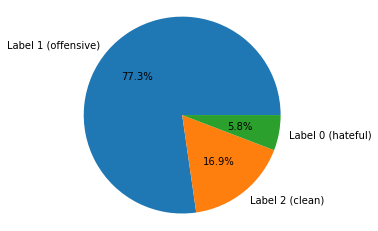

In [15]:
# Class Imbalance Check
plt.pie(train_set['class'].value_counts(), 
        labels=['Label 1 (offensive)', 'Label 2 (clean)','Label 0 (hateful)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

(27579, 17295) (27579,)
(34473, 20045) (34473,)


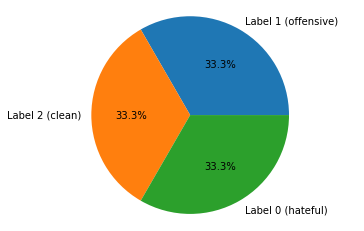

In [16]:
from imblearn.over_sampling import SMOTE
# SMOTE to deal with the class imbalance
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_tweets_tfidf, train_y.values)
print(X_train_smote.shape, y_train_smote.shape)

# SMOTE on full training data
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_tweets_tfidf, y.values)
print(X_smote.shape, y_smote.shape)

# Class Imbalance Check
plt.pie(pd.value_counts(y_train_smote), 
        labels=['Label 1 (offensive)', 'Label 2 (clean)','Label 0 (hateful)'], 
        autopct='%0.1f%%')
plt.axis('equal')
plt.show()

In [17]:
# Functions to print scores
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = f1_score(y_act, y_pred,average=None)
    print(f'Training Scores: Accuracy={acc}, F1-Score={f1}')
    
def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    f1 = f1_score(y_act, y_pred,average=None)
    print(f'Validation Scores: Accuracy={acc}, F1-Score={f1}')

### Model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

### Logistic Regression

In [43]:
from sklearn.model_selection import GridSearchCV
# Fit primal logistic regression
param_grid = {'C': [0.1,0.5,1,10,50,100], 'max_iter': [1000,1500,2000], 'fit_intercept':[True],'intercept_scaling':[1],
            'penalty':['l2'], 'tol':[0.00001,0.0001,0.000001]}
log_primal_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'),param_grid, cv=10, refit=True, verbose=0)
def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    best = model.best_estimator_
    # print(best)
    return best

In [44]:
log_primal_Grid.fit(X_smote, y_smote)
n = best_model(log_primal_Grid)
#fit best model
log_primal = n
log_primal.fit(X_smote, y_smote)
log_pred = log_primal.predict(test_tweets_tfidf)

0.9711369027305764
{'C': 50, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'tol': 1e-05}
LogisticRegression(C=50, max_iter=1000, tol=1e-05)


In [41]:
test_df = pd.DataFrame(log_pred)
test_df.columns = ['class']
test_df.to_csv('log_c20_max1000_test.csv')

In [20]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_smote, y_train_smote)
y_train_pred = lr.predict(X_train_smote)
y_test_pred = lr.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(val_y, y_test_pred)

Training Scores: Accuracy=0.973, F1-Score=[0.97522872 0.95922591 0.98439854]
Validation Scores: Accuracy=0.863, F1-Score=[0.41452991 0.91552511 0.84363636]


C:\Users\yuanhsu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
from sklearn.metrics import confusion_matrix
lbl = [0,1,2]
arr = confusion_matrix(val_y, y_test_pred, labels=lbl)

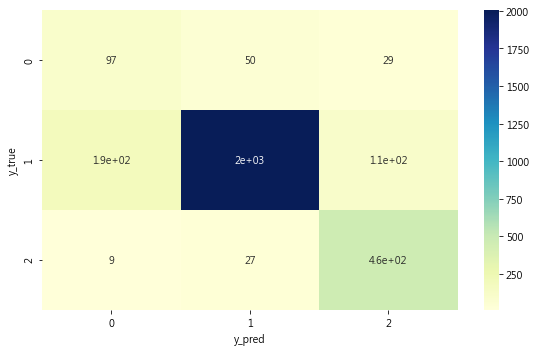

In [34]:
# 繪熱圖
df_cm = pd.DataFrame(arr, index = [i for i in lbl], columns = [i for i in lbl])
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 顯示中文
plt.figure(figsize = (8,5))  

sns.heatmap(df_cm, annot=True, cmap="YlGnBu");

plt.ylabel('y_true')
plt.xlabel('y_pred');
plt.tight_layout()

In [ ]:
test_pred = log.predict(test_tweets_tfidf)
test_df = pd.DataFrame(test_pred)
test_df.columns = ['class']
test_df.to_csv('log_test.csv')

### Multinomial NB

In [ ]:
param = [{'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]}]  # creating parameter grid
 
# Optimal C by grid search 
NB_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
Multinomial_NB = GridSearchCV(NB_clf, param, scoring = 'f1_micro', cv=10)
Multinomial_NB.fit(X_smote, y_smote)
n= best_model(Multinomial_NB)
#fit best model
MNB = n
MNB.fit(X_smote, y_smote)
mnb_pred = MNB.predict(test_tweets_tfidf)

In [ ]:
test_df = pd.DataFrame(mnb_pred)
test_df.columns = ['class']
test_df.to_csv('mnb_c20_max1000_test.csv')

In [78]:
from sklearn.naive_bayes import MultinomialNB
# Naive Bayes Classifier
mnb = MultinomialNB()
mnb_model = mnb.fit(X_train_smote, y_train_smote)
y_train_pred = mnb.predict(X_train_smote)
y_test_pred_NB = mnb.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(val_y, y_test_pred_NB)

Training Scores: Accuracy=0.955, F1-Score=[0.95341403 0.93397563 0.97666848]
Validation Scores: Accuracy=0.79, F1-Score=[0.29699842 0.86663569 0.76953511]


In [75]:
test_pred_NB = mnb.predict(test_tweets_tfidf)
test_df = pd.DataFrame(test_pred_NB)
test_df.columns = ['class']
test_df.to_csv('NB_nosmote_test.csv')

### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
# Fit rf
param_grid = {'max_depth': [10], 'max_features': [11],'n_estimators':[1000], 'min_samples_split': [5]}
RanFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, refit=True, verbose=0)
RanFor_grid.fit(X_smote, y_smote)
n= best_model(RanFor_grid)
#fit best model
RF = n
RF.fit(X_smote, y_smote)
rf_pred = RF.predict(test_tweets_tfidf)

0.9161110118284368
{'max_depth': 10, 'max_features': 11, 'min_samples_split': 5, 'n_estimators': 1000}
RandomForestClassifier(max_depth=10, max_features=11, min_samples_split=5,
                       n_estimators=1000)


In [51]:
test_df = pd.DataFrame(rf_pred)
test_df.columns = ['class']
test_df.to_csv('rf_n1000_max1000_test.csv')

In [ ]:
# rf nosmote
rf_n = RandomForestClassifier(criterion='entropy', max_samples=0.8, 
                            min_samples_split=10, random_state=0)
rf_n.fit(X_train_tweets_tfidf, train_y)
y_train_pred = rf_n.predict(X_train_tweets_tfidf)
y_test_pred = rf_n.predict(X_test_tweets_tfidf)
training_scores(train_y, y_train_pred)
validation_scores(val_y, y_test_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
rf = RandomForestClassifier(criterion='entropy', max_samples=0.8, 
                            min_samples_split=10, random_state=0)
rf.fit(X_train_smote, y_train_smote)
y_train_pred = rf.predict(X_train_smote)
y_test_pred = rf.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(val_y, y_test_pred)

In [ ]:
test_pred_rf = rf_n.predict(test_tweets_tfidf)
test_df = pd.DataFrame(test_pred_rf)
test_df.columns = ['class']
test_df.to_csv('rf_n_test_tune.csv')

### XGB

In [71]:
# Extreme Gradient Boosting Classifier
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', 
                    learning_rate=0.8, max_depth=20, gamma=0.6, 
                    reg_lambda=0.1, reg_alpha=0.1)
xgb_model = xgb.fit(X_train_smote, y_train_smote)
y_train_pred = xgb.predict(X_train_smote)
y_test_pred = xgb.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(val_y, y_test_pred)

Training Scores: Accuracy=0.996, F1-Score=[0.99733072 0.99400806 0.99625874]
Validation Scores: Accuracy=0.886, F1-Score=[0.33333333 0.93365343 0.84440228]


In [56]:
test_pred_xgb = xgb.predict(test_tweets_tfidf)
test_df = pd.DataFrame(test_pred_xgb)
test_df.columns = ['class']
test_df.to_csv('xgb_nosmote_test.csv')

In [ ]:
accuracy = model_selection.cross_val_score(xgb_model, 
                                           X_test_tweets_tfidf, 
                                           val_y, 
                                           cv = 20).mean()
print(accuracy)

### LightGBM

In [77]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(X_train_smote, y_train_smote)
y_train_pred = lgbm.predict(X_train_smote)
y_test_pred = lgbm.predict(X_test_tweets_tfidf)
training_scores(y_train_smote, y_train_pred)
validation_scores(val_y, y_test_pred)

Training Scores: Accuracy=0.97, F1-Score=[0.97290841 0.95689226 0.97889436]
Validation Scores: Accuracy=0.887, F1-Score=[0.42895442 0.93217701 0.85528757]


In [73]:
test_pred_lgbm = lgbm.predict(test_tweets_tfidf)
test_df = pd.DataFrame(test_pred_lgbm)
test_df.columns = ['class']
test_df.to_csv('lgbm_nosmote_param_test.csv')

In [ ]:
accuracy = model_selection.cross_val_score(lgbm_model, 
                                           X_test_tweets_tfidf, 
                                           val_y, 
                                           cv = 20).mean()
print(accuracy)